In [1]:
import os
import warnings
import joblib
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from tqdm import tqdm
from lazypredict.Supervised import LazyRegressor, LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed 
from sklearn import ensemble, linear_model, svm
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from test_diff_models import *
from success_utils import *

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Create a dictionary to group countries by region
region_groups = {
    "North America": ["HI", "Mexico", "NV", "OK", "NM","CA", "NY", "MD", "DC", "WA", "CO", "MN", "TX", "SC", "GA", "KY", "PA", "MI", "OH", "OR", "NC", "IL", "AZ", "TN", "NJ", "UT", "VA", "ND", "VT", "IA", "ND", "VT", "LA", "CT", "RI"],
    "Europe": ["Martinique", "AL", "Cayman Islands", "Russia", "ME", "UK", "DE", "Poland", "Denmark", "Netherlands", "Norway", "Liechtenstein", "Austria", "Belgium", "Czech Republic", "Iceland", "Ireland", "France", "Spain", "Sweden", "Switzerland", "Italy", "Slovenia", "Greece"],
    "Asia": ["MO", "IN", "Japan", "China", "Hong Kong", "India", "Viet Nam", "Taiwan", "Afghanistan", "Israel","Sri Lanka", "Jordan"],
    "South America": ["Colombia", "Brazil"],
    "Africa": ["WI", "SD", "MA", "Ghana", "Ethiopia", "Liberia", "Rwanda"],
    "Oceania": ["AU", "NZ"],
    "Other": [ "United Arab Emirates", "Svalbard and Jan Mayen"]
}

noticable_entities = ['ORG', 'PERSON', 'DATE',
                        'CARDINAL', 'GPE', 'PRODUCT', 
                        'WORK_OF_ART','ORDINAL', 'MONEY',
                        'TIME', 'NORP']


data_path = '/workspaces/Crowdfunding-Social-Media-Drivers/Data/Kickstarter_only/final_data.csv'
success_data = pd.read_csv(data_path)
success_data['collection_ratio'] = success_data.collected.apply(decode_amount)/success_data.goal_amount.apply(decode_amount)


bins = [0, 7, 14, 30, 60]
labels = ['<1 week', '1-2 weeks', '2 weeks - 1 month', '1-2 months']
success_data['duration'] = pd.cut(success_data['duration'], bins=bins, labels=labels)
success_data= success_data[success_data.donate != 1].reset_index(drop=True)


success_weights = (1-success_data.success.value_counts()/len(success_data)).values


def get_region(country):
    for region, countries in region_groups.items():
        if country in countries:
            return region
    return "Other"

success_data['region'] = success_data.country.str.strip().apply(get_region)
success_data.num_backers = success_data.num_backers.str.replace(',', '').astype(int)
success_data = success_data[success_data.region == 'North America']

success_data = pd.get_dummies(
                    success_data,
                    columns=['fb_type', 
                              'duration'])


for entity in noticable_entities:
    success_data[f'fb_entity_{entity}'] = success_data.fb_entities_identified.fillna('None').str.split(',').apply(lambda entity_list: entity in entity_list).astype(int)
    

bool_cols = success_data.dtypes[success_data.dtypes == 'bool'].index.tolist()
success_data[bool_cols] = success_data[bool_cols].astype(int)

#ecoding the number of backers
success_data.num_backers = encode_targets(success_data.num_backers)
success_data.population = np.exp(success_data.population)


success_data.head()

,collected,goal_amount,num_backers,category,pledge_types,donate,project_we_love,success,start_month,start_day,population,country,Person,Team,num_projects,num_backed,verified,fb_page_name,fb_likes_at_posting,fb_followers_at_posting,fb_likes,fb_comments,fb_shares,fb_post_views,fb_readability,fb_readability_lix,fb_entropy_scores,fb_perplexity_scores,fb_fear,fb_anger,fb_anticip,fb_trust,fb_surprise,fb_positive,fb_negative,fb_sadness,fb_disgust,fb_joy,fb_entities_identified,fb_post_sponsored,fb_post_age,fb_page_age,fb_positive_reactions,fb_negative_reactions,fb_topic_0,fb_topic_1,fb_topic_2,fb_topic_3,fb_topic_4,fb_topic_5,fb_topic_6,fb_topic_7,fb_topic_8,fb_topic_9,fb_topic_10,collection_ratio,region,fb_type_link,fb_type_photo,fb_type_video,duration_<1 week,duration_1-2 weeks,duration_2 weeks - 1 month,duration_1-2 months,fb_entity_ORG,fb_entity_PERSON,fb_entity_DATE,fb_entity_CARDINAL,fb_entity_GPE,fb_entity_PRODUCT,fb_entity_WORK_OF_ART,fb_entity_ORDINAL,fb_entity_MONEY,fb_entity_TIME,fb_entity_NORP
2,12.96,10.82,6.82,design,4.00,0.00,1.00,1,6,1,684451.00,WA,0,1,7,16,Marc Barros,Kickstarter,1589901,1588019,10,2,1,12,4.84,33.73,0.72,2.05,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,PRODUCT,0,2,4839,2,0,0.00,0.00,0.00,0.24,0.00,0.00,0.45,0.08,0.09,0.00,0.12,8.51,North America,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,11.87,9.90,6.95,comics,8.00,0.00,1.00,1,6,1,105319.00,CA,1,0,3,88,Adam Lawson,Kickstarter,1589930,1588019,4,1,0,5,6.93,29.11,0.63,1.87,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"CARDINAL,PERSON",0,8,4839,0,1,0.00,0.00,0.94,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.12,North America,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0
5,10.37,10.31,5.32,film_Video,13.00,0.00,1.00,1,6,1,8175133.00,NY,1,0,1,2,Julia Greenberg,Kickstarter,1589715,1587803,3,1,0,4,15.90,61.67,0.28,1.33,0.29,0.00,0.00,0.00,0.00,0.29,0.14,0.00,0.00,0.14,"PERSON,GPE",0,9,4839,0,1,0.00,0.15,0.00,0.08,0.00,0.13,0.00,0.16,0.29,0.16,0.00,1.07,North America,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0
6,9.54,8.80,5.56,comics,16.00,0.00,1.00,1,6,1,3971883.00,CA,0,1,4,23,Donold Wooldridge,Kickstarter,1589715,1587803,3,5,1,5,14.24,45.00,0.57,1.77,0.20,0.20,0.00,0.00,0.00,0.00,0.40,0.20,0.00,0.00,WORK_OF_ART,0,10,4839,1,1,0.00,0.00,0.16,0.00,0.00,0.00,0.06,0.06,0.06,0.63,0.00,2.09,North America,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
8,11.35,9.21,7.05,games,27.00,0.00,1.00,1,6,4,621849.00,MD,1,0,5,21,Amanda Coronado,Kickstarter,1589543,1587618,9,3,1,11,3.08,20.33,0.47,1.59,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,"PERSON,CARDINAL",0,14,4839,1,1,0.00,0.00,0.07,0.80,0.00,0.00,0.00,0.00,0.00,0.00,0.10,8.47,North America,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0


In [2]:
dropping_columns = ['collected', 'verified', 'donate', 'project_we_love', 'Team' ,'country', 'fb_page_name', 'region', 'fb_entities_identified', 'population', 'category']

success_data.drop(columns=dropping_columns, axis=1, inplace=True)
success_data = success_data[success_data.collection_ratio < 10].reset_index(drop=True)
success_data.pledge_types = success_data.pledge_types.astype(int)
success_data.num_projects = success_data.num_projects.astype(int)
success_data.num_backed = success_data.num_backed.astype(int)


In [3]:
#identify and list all the boolean features disguised as int in the dataset
bool_features = []
for col in success_data.columns:
    if success_data[col].nunique() == 2:
        bool_features.append(col)

bool_features.remove('success')

In [4]:
entity_features = [x for x in bool_features if 'fb_entity' in x]
duration_features = [x for x in bool_features if 'duration' in x]
region_features = [x for x in bool_features if 'region' in x]


In [5]:
# from sklearn.decomposition import PCA, TruncatedSVD
# def save_embedding_info(loadings, entity_features, name):
#     # Create a dataframe to store the loadings
#     loadings_df = pd.DataFrame(loadings, columns=entity_features)

#     plt.figure(figsize=(20, 10))
#     sns.heatmap(loadings_df, cmap='RdBu', center=0, annot=True)
#     save_path = '/workspaces/Crowdfunding-Social-Media-Drivers/Modelling/02_success_engagement/heatmaps for embeddings'
#     plt.savefig(save_path + f'/{name}.png', bbox_inches='tight')

# def try_svd(df, cols):
#     for i in range(1, len(cols)):
#         svd = TruncatedSVD(n_components=i)
#         svd.fit(df[cols])
#         evr = svd.explained_variance_ratio_.sum()
#         print(f'Explained variance ratio for {i} components: {svd.explained_variance_ratio_.sum()}')
#         if evr > 0.8:
#             return svd, i

# def append_embeddings(embeddings, df, col):
#     for i in range(embeddings.shape[1]):
#         df[f'{col}_embedding_{i}'] = embeddings[:,i]
#     return df

# svd, n_components = try_svd(success_data, entity_features)
# embddings = svd.fit_transform(success_data[entity_features])
# loadings = svd.components_
# save_embedding_info(loadings, entity_features, 'fb_entities')

# success_data = append_embeddings(embddings, success_data, 'fb_entities')

# svd, n_components = try_svd(success_data, region_features)
# embddings = svd.fit_transform(success_data[region_features])
# loadings = svd.components_
# save_embedding_info(loadings, region_features, 'region')

# success_data = append_embeddings(embddings, success_data, 'region')

# svd, n_components = try_svd(success_data, categories)
# embddings = svd.fit_transform(success_data[categories])
# loadings = svd.components_
# save_embedding_info(loadings, categories, 'categories')

# success_data = append_embeddings(embddings, success_data, 'categories')

# success_data.drop(columns=entity_features + region_features + categories, axis=1, inplace=True)

In [6]:
success_data.num_backers = np.exp(success_data.num_backers)
target_cols = [
    'success',
    'collection_ratio',
    'num_backers'
]

fb_cols = success_data.columns[success_data.columns.str.startswith('fb')].tolist()
common_features= success_data.columns[~success_data.columns.str.startswith('fb')].tolist()
common_features = [feature for feature in common_features if feature not in target_cols]

engagement_features = [ 'fb_likes', 'fb_comments', 'fb_shares','fb_positive_reactions','fb_negative_reactions']
post_fb_features = [feature for feature in fb_cols if feature not in engagement_features]


In [7]:
domain_page_features = success_data[common_features]
domain_engagement_features = success_data[common_features + engagement_features]
domain_post_features = success_data[common_features + post_fb_features]

targets = success_data[target_cols]

In [8]:
pd.concat([domain_page_features, targets], axis=1).to_csv('/workspaces/Crowdfunding-Social-Media-Drivers/Data/final_datasets/domain_only.csv', index=False)
pd.concat([domain_engagement_features, targets], axis=1).to_csv('/workspaces/Crowdfunding-Social-Media-Drivers/Data/final_datasets/domain_engagement.csv', index=False)
pd.concat([domain_post_features, targets], axis=1).to_csv('/workspaces/Crowdfunding-Social-Media-Drivers/Data/final_datasets/domain_post.csv', index=False)

In [9]:
print(common_features)

['goal_amount', 'pledge_types', 'start_month', 'start_day', 'Person', 'num_projects', 'num_backed', 'duration_<1 week', 'duration_1-2 weeks', 'duration_2 weeks - 1 month', 'duration_1-2 months']


## Modelling

In [10]:
working_data = 'domain_post'
domain_post = pd.read_csv(f'/workspaces/Crowdfunding-Social-Media-Drivers/Data/final_datasets/{working_data}.csv')

In [11]:
domain_post.loc[:,target_cols].head()

,success,collection_ratio,num_backers
0,1,8.51,919.00
1,1,7.12,1048.00
2,1,1.07,204.00
3,1,2.09,259.00
4,1,8.47,1155.00


In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(domain_post.drop(target_cols, axis=1), domain_post[target_cols], test_size=0.2, random_state=42, stratify=domain_post.success)

X_train = X_train.reset_index(drop=True).values
X_test = X_test.reset_index(drop=True).values
y_train = y_train.reset_index(drop=True).values
y_test = y_test.reset_index(drop=True).values

* y[:, 0] => Success (Boolean)
* y[:,1] => Collection Ratio
* y[:,2] => Number of Backers


In [108]:
reg_test = RegressionModels(X_train, X_test, y_train[:,1], y_test[:,1], decode=False)
reg_test.run_evaluation()
print(reg_test.not_trained_)
print(reg_test.not_evaluated_)
reg_test.top_10_socres

Evaluating models: 100%|██████████| 40/40 [00:00<00:00, 179.29it/s]

All models were trained successfully.
All models were evaluated successfully.


,RMSE,MAE,R2,EV Score
ExtraTreesRegressor,1.79,1.27,0.18,0.19
RandomForestRegressor,1.79,1.25,0.18,0.19
GradientBoostingRegressor,1.82,1.26,0.15,0.16
TheilSenRegressor,1.84,1.34,0.13,0.16
RidgeCV,1.85,1.30,0.13,0.15
LassoLarsIC,1.86,1.33,0.12,0.14
Ridge,1.86,1.34,0.11,0.14
KernelRidge,1.87,1.35,0.11,0.13
LinearRegression,1.88,1.36,0.10,0.12
ARDRegression,1.88,1.33,0.10,0.11


In [109]:
reg_test = RegressionModels(X_train, X_test, y_train[:,2], y_test[:,2], decode=False)
reg_test.run_evaluation()
print(reg_test.not_trained_)
print(reg_test.not_evaluated_)
reg_test.top_10_socres

Evaluating models: 100%|██████████| 40/40 [00:00<00:00, 205.57it/s]


All models were trained successfully.
All models were evaluated successfully.


,RMSE,MAE,R2,EV Score
ExtraTreesRegressor,3750.46,1101.51,0.27,0.28
RandomForestRegressor,3763.70,1156.91,0.27,0.28
BaggingRegressor,3798.49,1175.64,0.25,0.26
GradientBoostingRegressor,3838.39,1191.75,0.24,0.25
AdaBoostRegressor,3844.34,1553.61,0.23,0.23
XGBRegressor,3858.00,1169.54,0.23,0.24
KernelRidge,4012.75,1295.53,0.17,0.19
LinearRegression,4015.51,1303.65,0.16,0.19
Lasso,4017.63,1288.95,0.16,0.19
LassoLars,4017.63,1288.95,0.16,0.19


In [110]:
reg_test = RegressionModels(X_train, X_test, encode_targets(y_train[:,2]), encode_targets(y_test[:,2]), decode=False)
reg_test.run_evaluation()
print(reg_test.not_trained_)
print(reg_test.not_evaluated_)
reg_test.top_10_socres

Evaluating models: 100%|██████████| 40/40 [00:00<00:00, 173.06it/s]

All models were trained successfully.
All models were evaluated successfully.


,RMSE,MAE,R2,EV Score
RidgeCV,0.97,0.78,0.47,0.47
LassoLarsCV,0.97,0.78,0.47,0.47
LassoLarsIC,0.97,0.78,0.46,0.47
BayesianRidge,0.97,0.78,0.46,0.47
KernelRidge,0.98,0.80,0.45,0.46
ExtraTreesRegressor,0.99,0.79,0.45,0.46
Ridge,0.99,0.80,0.45,0.45
ARDRegression,0.99,0.81,0.44,0.45
LinearRegression,1.00,0.81,0.44,0.44
RandomForestRegressor,1.00,0.80,0.43,0.43


In [111]:
cls_test = ClassificationModels(X_train, X_test, y_train[:,0], y_test[:,0])
cls_test.run_evaluation()
print(cls_test.not_trained_)
print(cls_test.not_evaluated_)
cls_test.top_10_socres

Evaluating models: 100%|██████████| 27/27 [00:00<00:00, 80.69it/s] 

The modelsNu-Support Vector Machine could not be trained.
The modelsKernel Ridge could not be evaluated.


,Accuracy,Precision,Recall,F1 Score,ROC AUC,Class-0 Acc,Class-1 Acc
Balanced Random Forest Classifier,0.64,0.97,0.62,0.75,0.72,0.82,0.62
Gaussian Process,0.13,0.71,0.05,0.09,0.43,0.82,0.05
Gaussian Naive Bayes,0.54,0.94,0.52,0.67,0.62,0.73,0.52
Easy Ensemble Classifier,0.57,0.93,0.57,0.70,0.60,0.64,0.57
RUSBoost Classifier,0.77,0.93,0.81,0.86,0.63,0.45,0.81
Balanced Bagging Classifier,0.72,0.93,0.75,0.83,0.60,0.45,0.75
Multinomial Naive Bayes,0.63,0.88,0.68,0.77,0.43,0.18,0.68
AdaBoost,0.89,0.91,0.97,0.94,0.58,0.18,0.97
Support Vector Machine,0.90,0.90,1.00,0.95,0.50,0.00,1.00
Dummy Classifier,0.90,0.90,1.00,0.95,0.50,0.00,1.00


## Further Finetuning of the topk models

### Collection Ratio

In [157]:
# Collection Ratio
random_forest_param_grid = {
    'n_estimators': [80, 100, 500],
    'max_depth': [None, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': [None],
    'bootstrap': [True], 
    'random_state': [42]
}

scores = []
for param in tqdm(ParameterGrid(random_forest_param_grid)):
    rf = ensemble.RandomForestRegressor(**param)
    rf.fit(X_train, y_train[:,1])
    y_pred = rf.predict(X_test)

    scores.append({
        'params': param,
        'r2': r2_score(y_test[:,1], y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test[:,1], y_pred)),
        'rmsle': np.sqrt(mean_squared_log_error(y_test[:,1], y_pred))
    })

pd.DataFrame(scores).sort_values(by='r2', ascending=False).reset_index(drop=True).head(5)

100%|██████████| 48/48 [01:28<00:00,  1.83s/it]


,params,r2,rmse,rmsle
26,"{'bootstrap': False, 'max_depth': None, 'max_f...",-0.76,2.62,0.63
25,"{'bootstrap': False, 'max_depth': None, 'max_f...",-0.76,2.62,0.63
35,"{'bootstrap': False, 'max_depth': None, 'max_f...",-0.75,2.62,0.62
24,"{'bootstrap': False, 'max_depth': None, 'max_f...",-0.75,2.62,0.62
30,"{'bootstrap': False, 'max_depth': None, 'max_f...",-0.75,2.62,0.61


In [164]:
for param in pd.DataFrame(scores).sort_values(by='r2', ascending=False).reset_index(drop=True).head(5).params:
    print(param)


{'bootstrap': True, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 80, 'random_state': 42}
{'bootstrap': True, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 42}
{'bootstrap': True, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500, 'random_state': 42}
{'bootstrap': True, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}
{'bootstrap': True, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500, 'random_state': 42}


In [165]:
# Collection Ratio
random_forest_param_grid = {
    'n_estimators': [80, 100, 500],
    'max_depth': [None],
    'min_samples_split': [2, 3, 4, 5, 10],
    'min_samples_leaf': [1],
    'max_features': [None],
    'bootstrap': [True], 
    'random_state': [42]
}

scores = []
for param in tqdm(ParameterGrid(random_forest_param_grid)):
    rf = ensemble.RandomForestRegressor(**param)
    rf.fit(X_train, y_train[:,1])
    y_pred = rf.predict(X_test)

    scores.append({
        'params': param,
        'r2': r2_score(y_test[:,1], y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test[:,1], y_pred)),
        'rmsle': np.sqrt(mean_squared_log_error(y_test[:,1], y_pred))
    })

pd.DataFrame(scores).sort_values(by='r2', ascending=False).reset_index(drop=True).head(5)
for param in pd.DataFrame(scores).sort_values(by='r2', ascending=False).reset_index(drop=True).head(5).params:
    print(param)

100%|██████████| 15/15 [00:34<00:00,  2.28s/it]


,params,r2,rmse,rmsle
0,"{'bootstrap': True, 'max_depth': None, 'max_fe...",0.19,1.78,0.46
1,"{'bootstrap': True, 'max_depth': None, 'max_fe...",0.18,1.79,0.46
2,"{'bootstrap': True, 'max_depth': None, 'max_fe...",0.18,1.79,0.46
3,"{'bootstrap': True, 'max_depth': None, 'max_fe...",0.18,1.79,0.46
4,"{'bootstrap': True, 'max_depth': None, 'max_fe...",0.18,1.79,0.46


In [167]:
# Collection Ratio
random_forest_param_grid = {
    'n_estimators': [80, 100, 500],
    'max_depth': [None],
    'min_samples_split': [3, 4, 10, 20, 30],
    'min_samples_leaf': [1],
    'max_features': [None],
    'bootstrap': [True], 
    'random_state': [42]
}

scores = []
for param in tqdm(ParameterGrid(random_forest_param_grid)):
    rf = ensemble.RandomForestRegressor(**param)
    rf.fit(X_train, y_train[:,1])
    y_pred = rf.predict(X_test)

    scores.append({
        'params': param,
        'r2': r2_score(y_test[:,1], y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test[:,1], y_pred)),
        'rmsle': np.sqrt(mean_squared_log_error(y_test[:,1], y_pred))
    })

for param in pd.DataFrame(scores).sort_values(by='r2', ascending=False).reset_index(drop=True).head(5).params:
    print(param)

100%|██████████| 15/15 [00:31<00:00,  2.10s/it]

{'bootstrap': True, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 30, 'n_estimators': 80, 'random_state': 42}
{'bootstrap': True, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 80, 'random_state': 42}
{'bootstrap': True, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 80, 'random_state': 42}
{'bootstrap': True, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 30, 'n_estimators': 100, 'random_state': 42}
{'bootstrap': True, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 100, 'random_state': 42}


In [168]:
pd.DataFrame(scores).sort_values(by='r2', ascending=False).reset_index(drop=True).head(5)


,params,r2,rmse,rmsle
0,"{'bootstrap': True, 'max_depth': None, 'max_fe...",0.19,1.78,0.45
1,"{'bootstrap': True, 'max_depth': None, 'max_fe...",0.19,1.78,0.46
2,"{'bootstrap': True, 'max_depth': None, 'max_fe...",0.18,1.79,0.45
3,"{'bootstrap': True, 'max_depth': None, 'max_fe...",0.18,1.79,0.45
4,"{'bootstrap': True, 'max_depth': None, 'max_fe...",0.18,1.79,0.45


In [125]:
rf = ensemble.RandomForestRegressor(random_state=42, n_estimators=80)
rf.fit(X_train, y_train[:,1])

y_pred = rf.predict(X_test)

print(f'RMSE: {np.sqrt(mean_squared_error(y_test[:,1], y_pred)):.2f}')
print(f'R2: {r2_score(y_test[:,1], y_pred)}')
print(f'MSLE: {mean_squared_log_error(y_test[:,1], y_pred):.2f}')

RMSE: 1.79
R2: 0.1779942966403969
MSLE: 0.21


In [147]:
### Collection_ratio,
extra_trees_params = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [None, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': [None],
    'random_state': [42]
}


scores = []
for param in tqdm(ParameterGrid(extra_trees_params)):
    extra_trees_regressor = ensemble.ExtraTreesRegressor(**param)
    extra_trees_regressor.fit(X_train, y_train[:,1])

    y_pred = extra_trees_regressor.predict(X_test)
    scores.append({
        'params': param,
        'rmse': np.sqrt(mean_squared_error(y_test[:,1], y_pred)),
        'r2': r2_score(y_test[:,1], y_pred),
        'msle': mean_squared_log_error(y_test[:,1], y_pred)
    })

scores_df = pd.DataFrame(scores)

  1%|▏         | 1/72 [00:00<00:07,  9.30it/s]

100%|██████████| 72/72 [00:49<00:00,  1.44it/s]


In [172]:
for param in scores_df.sort_values(by='r2', ascending=False).head(5).params:
    print(param)

{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500, 'random_state': 42}
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000, 'random_state': 42}
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 42}
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500, 'random_state': 42}
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}


In [174]:
### Collection_ratio, extra trees, v2
extra_trees_params = {
    'n_estimators': [500, 1000],
    'max_depth': [None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1,],
    'max_features': [None],
    'random_state': [42]
}


scores = []
for param in tqdm(ParameterGrid(extra_trees_params)):
    extra_trees_regressor = ensemble.ExtraTreesRegressor(**param)
    extra_trees_regressor.fit(X_train, y_train[:,1])

    y_pred = extra_trees_regressor.predict(X_test)
    scores.append({
        'params': param,
        'rmse': np.sqrt(mean_squared_error(y_test[:,1], y_pred)),
        'r2': r2_score(y_test[:,1], y_pred),
        'msle': mean_squared_log_error(y_test[:,1], y_pred)
    })

scores_df = pd.DataFrame(scores)

100%|██████████| 8/8 [00:17<00:00,  2.20s/it]


In [175]:
scores_df.sort_values(by='r2', ascending=False).head(5)

,params,rmse,r2,msle
2,"{'max_depth': None, 'max_features': None, 'min...",1.74,0.22,0.20
3,"{'max_depth': None, 'max_features': None, 'min...",1.75,0.22,0.20
5,"{'max_depth': None, 'max_features': None, 'min...",1.76,0.21,0.20
1,"{'max_depth': None, 'max_features': None, 'min...",1.76,0.21,0.20
0,"{'max_depth': None, 'max_features': None, 'min...",1.76,0.21,0.20


In [176]:
for param in scores_df.sort_values(by='r2', ascending=False).head(5).params:
    print(param)

{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500, 'random_state': 42}
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000, 'random_state': 42}
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000, 'random_state': 42}
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 42}
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500, 'random_state': 42}


In [177]:
### Collection_ratio, extra trees, v2
extra_trees_params = {
    'n_estimators': [500, 1000],
    'max_depth': [None],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1,],
    'max_features': [None],
    'random_state': [42]
}


scores = []
for param in tqdm(ParameterGrid(extra_trees_params)):
    extra_trees_regressor = ensemble.ExtraTreesRegressor(**param)
    extra_trees_regressor.fit(X_train, y_train[:,1])

    y_pred = extra_trees_regressor.predict(X_test)
    scores.append({
        'params': param,
        'rmse': np.sqrt(mean_squared_error(y_test[:,1], y_pred)),
        'r2': r2_score(y_test[:,1], y_pred),
        'msle': mean_squared_log_error(y_test[:,1], y_pred)
    })

scores_df = pd.DataFrame(scores)

100%|██████████| 8/8 [00:20<00:00,  2.58s/it]


In [178]:
scores_df.sort_values(by='r2', ascending=False).head(5)


,params,rmse,r2,msle
6,"{'max_depth': None, 'max_features': None, 'min...",1.74,0.22,0.20
7,"{'max_depth': None, 'max_features': None, 'min...",1.75,0.22,0.20
4,"{'max_depth': None, 'max_features': None, 'min...",1.75,0.22,0.20
5,"{'max_depth': None, 'max_features': None, 'min...",1.75,0.22,0.20
2,"{'max_depth': None, 'max_features': None, 'min...",1.76,0.21,0.20


In [179]:
for param in scores_df.sort_values(by='r2', ascending=False).head(5).params:
    print(param)

{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500, 'random_state': 42}
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000, 'random_state': 42}
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 500, 'random_state': 42}
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 1000, 'random_state': 42}
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 500, 'random_state': 42}


In [180]:
extra_trees_best_params = scores_df.sort_values(by='r2', ascending=False).reset_index(drop=True).params[0]
extra_trees_best_params

{'max_depth': None,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 500,
 'random_state': 42}

In [181]:
extra_trees_best = ensemble.ExtraTreesRegressor(**extra_trees_best_params)
extra_trees_best.fit(X_train, y_train[:,1])


ExtraTreesRegressor(max_features=None, min_samples_split=5, n_estimators=500,
                    random_state=42)

In [182]:
joblib.dump(extra_trees_best, '/workspaces/Crowdfunding-Social-Media-Drivers/Modelling/02_success_engagement/domain_post/collection_ratio.pkl')

['/workspaces/Crowdfunding-Social-Media-Drivers/Modelling/02_success_engagement/domain_post/collection_ratio.pkl']

### Number of Backers

In [184]:
encoded_y_backers = encode_targets(y_train[:,2])
encoded_y_test_backers = encode_targets(y_test[:,2])

In [191]:
default_ridgecv = linear_model.RidgeCV()
default_ridgecv.fit(X_train, encode_targets(y_train[:,2]))

y_pred = default_ridgecv.predict(X_test)

print(f'RMSE: {np.sqrt(mean_squared_error(y_test[:,2], y_pred)):.2f}')
print(f'R2: {r2_score(encode_targets(y_test[:,2]), y_pred)}')


RMSE: 4623.75
R2: 0.4667777556174947


In [208]:
decoded_y_pred = np.round(np.exp(y_pred)-1)

print(f'RMSE: {np.sqrt(mean_squared_error(y_test[:,2], decoded_y_pred)):.2f}')
print(f'R2: {r2_score(y_test[:,2], decoded_y_pred)}')


RMSE: 3910.68
R2: 0.20750911967528463


> Despite the encoded targets showing very good R2, when decoded, the R2 is not as good. 

Before Decoding: 

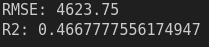

After Decoding:

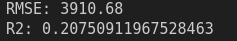

Hence, the best model with un-encoded training, is further finetuned. 

In [218]:
n_estimator_list = [80, 100, 250, 400, 450, 500, 600, 750, 1000]

for n_estimators in n_estimator_list:
    extra_trees_default = ensemble.ExtraTreesRegressor(random_state=42, n_estimators=n_estimators)
    extra_trees_default.fit(X_train, y_train[:,2])

    y_pred = extra_trees_default.predict(X_test)

    print(f'{n_estimators}, RMSE, R2: {np.sqrt(mean_squared_error(y_test[:,2], y_pred)):.2f}, {r2_score(y_test[:,2], y_pred)}')

80, RMSE, R2: 3744.80, 0.27331287456887976
100, RMSE, R2: 3750.46, 0.2711159843509897
250, RMSE, R2: 3718.54, 0.28346759900297036
400, RMSE, R2: 3717.34, 0.2839318920045223
450, RMSE, R2: 3714.46, 0.2850418112223223
500, RMSE, R2: 3710.52, 0.2865563151437861
600, RMSE, R2: 3712.51, 0.28579119390797814
750, RMSE, R2: 3721.52, 0.282319598418001
1000, RMSE, R2: 3725.04, 0.28096271861110333


In [227]:
n_estimator_list = [500, 505, 506, 507, 525, 530, 535, 536,537,538,539,540,550]

for n_estimators in n_estimator_list:
    extra_trees_default = ensemble.ExtraTreesRegressor(random_state=42, n_estimators=n_estimators)
    extra_trees_default.fit(X_train, y_train[:,2])

    y_pred = extra_trees_default.predict(X_test)

    print(f'{n_estimators}, RMSE, R2: {np.sqrt(mean_squared_error(y_test[:,2], y_pred)):.2f}, {r2_score(y_test[:,2], y_pred)}')

500, RMSE, R2: 3710.52, 0.2865563151437861
505, RMSE, R2: 3709.94, 0.28677729951575026
506, RMSE, R2: 3709.51, 0.2869432117676127
507, RMSE, R2: 3709.79, 0.2868361098574038
525, RMSE, R2: 3712.07, 0.2859609848521505
530, RMSE, R2: 3710.25, 0.286661427209851
535, RMSE, R2: 3709.37, 0.2870000601296455
536, RMSE, R2: 3708.92, 0.2871695649751673
537, RMSE, R2: 3708.68, 0.2872624927811761
538, RMSE, R2: 3709.63, 0.2868971697003323
539, RMSE, R2: 3709.47, 0.2869581769420182
540, RMSE, R2: 3709.24, 0.28704817589250997
550, RMSE, R2: 3711.35, 0.2862380353374059


In [13]:
### Collection_ratio,
extra_trees_params = {
    'n_estimators': [537],
    'max_depth': [None],
    'min_samples_split': [2, 5,10],
    'min_samples_leaf': [1, 2],
    'max_features': [None],
    'random_state': [42]
}


scores = []
for param in tqdm(ParameterGrid(extra_trees_params)):
    extra_trees_regressor = ensemble.ExtraTreesRegressor(**param)
    extra_trees_regressor.fit(X_train, y_train[:,2])

    y_pred = extra_trees_regressor.predict(X_test)
    scores.append({
        'params': param,
        'rmse': np.sqrt(mean_squared_error(y_test[:,2], y_pred)),
        'r2': r2_score(y_test[:,2], y_pred),
        'msle': mean_squared_log_error(y_test[:,2], y_pred)
    })

scores_df = pd.DataFrame(scores)
scores_df.sort_values(by='r2', ascending=False)

100%|██████████| 6/6 [00:08<00:00,  1.47s/it]


,params,rmse,r2,msle
0,"{'max_depth': None, 'max_features': None, 'min...",3708.68,0.29,1.15
2,"{'max_depth': None, 'max_features': None, 'min...",3732.89,0.28,1.12
1,"{'max_depth': None, 'max_features': None, 'min...",3734.60,0.28,1.14
3,"{'max_depth': None, 'max_features': None, 'min...",3833.95,0.24,1.11
5,"{'max_depth': None, 'max_features': None, 'min...",3840.83,0.24,1.09
4,"{'max_depth': None, 'max_features': None, 'min...",3841.37,0.24,1.11


In [14]:
extra_trees_best_params = scores_df.sort_values(by='r2', ascending=False).reset_index(drop=True).params[0]

extra_trees_best = ensemble.ExtraTreesRegressor(**extra_trees_best_params)
extra_trees_best.fit(X_train, y_train[:,2])

joblib.dump(extra_trees_best, '/workspaces/Crowdfunding-Social-Media-Drivers/Modelling/02_success_engagement/domain_post/num_backers.pkl')

['/workspaces/Crowdfunding-Social-Media-Drivers/Modelling/02_success_engagement/domain_post/num_backers.pkl']

### Success

In [235]:
n_estimator_list = [75, 100, 500, 1000]

for n_estimators in n_estimator_list:
    balanced_rf = BalancedRandomForestClassifier(random_state=42, n_estimators=n_estimators)
    balanced_rf.fit(X_train, y_train[:,0])

    y_pred = balanced_rf.predict(X_test)

    print(f'Accuracy: {accuracy_score(y_test[:,0], y_pred)}')
    print(classification_report(y_test[:,0], y_pred))

Accuracy: 0.6727272727272727
              precision    recall  f1-score   support

         0.0       0.14      0.45      0.22        11
         1.0       0.92      0.70      0.79        99

    accuracy                           0.67       110
   macro avg       0.53      0.58      0.51       110
weighted avg       0.84      0.67      0.74       110

Accuracy: 0.5909090909090909
              precision    recall  f1-score   support

         0.0       0.13      0.55      0.21        11
         1.0       0.92      0.60      0.72        99

    accuracy                           0.59       110
   macro avg       0.53      0.57      0.47       110
weighted avg       0.84      0.59      0.67       110

Accuracy: 0.6909090909090909
              precision    recall  f1-score   support

         0.0       0.21      0.73      0.32        11
         1.0       0.96      0.69      0.80        99

    accuracy                           0.69       110
   macro avg       0.58      0.71      0.

In [239]:
n_estimator_list = [470, 475, 480, 500, 520, 525, 527, 526, 528, 529, 530, 534]

for n_estimators in n_estimator_list:
    balanced_rf = BalancedRandomForestClassifier(random_state=42, n_estimators=n_estimators)
    balanced_rf.fit(X_train, y_train[:,0])

    y_pred = balanced_rf.predict(X_test)

    print(n_estimators)
    print(f'Accuracy: {accuracy_score(y_test[:,0], y_pred)}')
    print(classification_report(y_test[:,0], y_pred))
    print()

470
Accuracy: 0.6727272727272727
              precision    recall  f1-score   support

         0.0       0.20      0.73      0.31        11
         1.0       0.96      0.67      0.79        99

    accuracy                           0.67       110
   macro avg       0.58      0.70      0.55       110
weighted avg       0.88      0.67      0.74       110


475
Accuracy: 0.7
              precision    recall  f1-score   support

         0.0       0.21      0.73      0.33        11
         1.0       0.96      0.70      0.81        99

    accuracy                           0.70       110
   macro avg       0.58      0.71      0.57       110
weighted avg       0.88      0.70      0.76       110


480
Accuracy: 0.7
              precision    recall  f1-score   support

         0.0       0.21      0.73      0.33        11
         1.0       0.96      0.70      0.81        99

    accuracy                           0.70       110
   macro avg       0.58      0.71      0.57       110
wei

In [243]:
balanced_rf_params = {
    'n_estimators': [500,526,530,1000],
    'max_depth': [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'max_features': [None],
    'random_state': [42]
}

scores = []

for param in tqdm(ParameterGrid(balanced_rf_params)):
    easytrees = BalancedRandomForestClassifier(**param)
    easytrees.fit(X_train, y_train[:,0])

    y_pred = easytrees.predict(X_test)

    accuracy = accuracy_score(y_test[:,0], y_pred)
    precision = precision_score(y_test[:,0], y_pred)
    recall = recall_score(y_test[:,0], y_pred)
    f1 = f1_score(y_test[:,0], y_pred)
    roc_auc = roc_auc_score(y_test[:,0], y_pred)

    confusion_matrix = metrics.confusion_matrix(
        y_test[:,0], y_pred)
    
    #class_wise acc
    class_wise_acc = {}
    for i in range(2):
        class_wise_acc[i] = confusion_matrix[i][i] / sum(confusion_matrix[i])
    


    class_wise_acc_list = [class_wise_acc[i] for i in range(2)] 

    scores.append([param,
        accuracy, precision, recall, f1, roc_auc,
        ] + class_wise_acc_list)

scores_df = pd.DataFrame(scores)
scores_df.columns = ['params', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'class_0_acc', 'class_1_acc']

100%|██████████| 24/24 [00:38<00:00,  1.58s/it]


,0,1,2,3,4,5,6,7
0,"{'max_depth': None, 'max_features': None, 'min...",0.68,0.97,0.67,0.79,0.74,0.82,0.67
1,"{'max_depth': None, 'max_features': None, 'min...",0.67,0.97,0.66,0.78,0.74,0.82,0.66
2,"{'max_depth': None, 'max_features': None, 'min...",0.67,0.97,0.66,0.78,0.74,0.82,0.66
3,"{'max_depth': None, 'max_features': None, 'min...",0.67,0.96,0.67,0.79,0.70,0.73,0.67
4,"{'max_depth': None, 'max_features': None, 'min...",0.66,0.97,0.65,0.78,0.73,0.82,0.65
5,"{'max_depth': None, 'max_features': None, 'min...",0.66,0.97,0.65,0.78,0.73,0.82,0.65
6,"{'max_depth': None, 'max_features': None, 'min...",0.66,0.97,0.65,0.78,0.73,0.82,0.65
7,"{'max_depth': None, 'max_features': None, 'min...",0.66,0.96,0.66,0.78,0.69,0.73,0.66
8,"{'max_depth': None, 'max_features': None, 'min...",0.65,0.97,0.63,0.76,0.72,0.82,0.63
9,"{'max_depth': None, 'max_features': None, 'min...",0.67,0.97,0.66,0.78,0.74,0.82,0.66


In [245]:
scores_df.columns = ['params', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'class_0_acc', 'class_1_acc']
scores_df.sort_values(by=['class_0_acc', 'f1','class_1_acc'], ascending=False).head(5)

,params,accuracy,precision,recall,f1,roc_auc,class_0_acc,class_1_acc
0,"{'max_depth': None, 'max_features': None, 'min...",0.68,0.97,0.67,0.79,0.74,0.82,0.67
1,"{'max_depth': None, 'max_features': None, 'min...",0.67,0.97,0.66,0.78,0.74,0.82,0.66
2,"{'max_depth': None, 'max_features': None, 'min...",0.67,0.97,0.66,0.78,0.74,0.82,0.66
9,"{'max_depth': None, 'max_features': None, 'min...",0.67,0.97,0.66,0.78,0.74,0.82,0.66
10,"{'max_depth': None, 'max_features': None, 'min...",0.67,0.97,0.66,0.78,0.74,0.82,0.66


In [248]:
balanced_rf_best_params = scores_df.params[0]

balanced_rf_best = BalancedRandomForestClassifier(**balanced_rf_best_params)
balanced_rf_best.fit(X_train, y_train[:,0])


BalancedRandomForestClassifier(max_features=None, n_estimators=500,
                               random_state=42)

In [249]:

joblib.dump(balanced_rf_best, '/workspaces/Crowdfunding-Social-Media-Drivers/Modelling/02_success_engagement/domain_post/success.pkl')

['/workspaces/Crowdfunding-Social-Media-Drivers/Modelling/02_success_engagement/domain_post/success.pkl']